In [2]:
import numpy as np
import pandas as pd
import sqlite3
import warnings
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
#hyper parameters:
eta = 1500 ###starting elo
kappa = 100 #read in size
beta = 400 # +- on your opponents rating

In [4]:
#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect('data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

In [5]:
#get the french league
selected_countries = ['France']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id','season', 'home_team_api_id', 'away_team_api_id','home_team_goal', 'away_team_goal']]
# 'stage', 'date','match_api_id', removed columns
matches.dropna(inplace=True)

In [6]:
matches['D'] = np.where(matches.home_team_goal == matches.away_team_goal,1,0)
matches['HW'] = np.where(matches.home_team_goal > matches.away_team_goal,1,0)
matches['AW'] = np.where(matches.home_team_goal < matches.away_team_goal,1,0)
del matches['home_team_goal']
del matches['away_team_goal']

In [7]:
#create an elo database
t1 = matches.home_team_api_id.unique()
elo = [eta]*len(t1)
elo_df = pd.DataFrame({'team_id':t1, 'elo':elo},index=t1)

In [8]:
matches.head(n=3)

,id,season,home_team_api_id,away_team_api_id,D,HW,AW
4768,4769,2008/2009,8583,9830,0,1,0
4769,4770,2008/2009,9827,7819,0,1,0
4770,4771,2008/2009,9746,9831,0,1,0


In [9]:
matches = matches.merge(elo_df,how='left',left_on='home_team_api_id',right_on='team_id')
del matches['team_id']
matches.rename(columns={'elo': 'elo_home'}, inplace=True)
matches = matches.merge(elo_df,how='left',left_on='away_team_api_id',right_on='team_id')
del matches['team_id']
matches.rename(columns={'elo': 'elo_away'}, inplace=True)

In [10]:
## Read the first kappa records
mshort = matches.iloc[:kappa]

warnings.filterwarnings('ignore')
####

In [11]:
mshort['elo_home_change'] = np.where(mshort.HW == 1, mshort.elo_away+beta,mshort.elo_away-beta)
mshort['elo_away_change'] = np.where(mshort.AW == 1, mshort.elo_home+beta,mshort.elo_home-beta)
mshort['elo_home_change'][mshort.D==1] = mshort.elo_away
mshort['elo_away_change'][mshort.D==1] = mshort.elo_home

In [12]:
def elo_updator(team_id):
    elo_change = np.sum(mshort.elo_home_change[mshort.home_team_api_id==team_id])+np.sum(mshort.elo_away_change[mshort.away_team_api_id==team_id])
    count = np.sum(mshort.home_team_api_id==team_id)+np.sum(mshort.away_team_api_id==team_id)
    updated_value = elo_change/count
    try:
        elo_df.set_value(team_id,'elo',updated_value)
    except ValueError:
        ## if a team_id does not appear in this subset it has a non_changing elo
        pass

In [16]:
for x in matches.home_team_api_id.unique():
    elo_updator(x)

,id,season,home_team_api_id,away_team_api_id,D,HW,AW,elo_home,elo_away
0,4769,2008/2009,8583,9830,0,1,0,1500,1500
1,4770,2008/2009,9827,7819,0,1,0,1500,1500
2,4771,2008/2009,9746,9831,0,1,0,1500,1500
3,4772,2008/2009,8682,8689,0,0,1,1500,1500
4,4773,2008/2009,9748,9941,0,1,0,1500,1500


In [20]:
for x in matches.home_team_api_id.unique():
    matches.elo_home.iloc[kappa:2*kappa][matches.home_team_api_id==x] = elo_df.loc[x].elo
    matches.elo_away.iloc[kappa:2*kappa][matches.away_team_api_id==x] = elo_df.loc[x].elo

(array([  2.,   0.,   3.,   1.,   3.,  19.,   3.,   2.,   1.,   1.]),
 array([ 1260.,  1308.,  1356.,  1404.,  1452.,  1500.,  1548.,  1596.,
         1644.,  1692.,  1740.]),
 <a list of 10 Patch objects>)

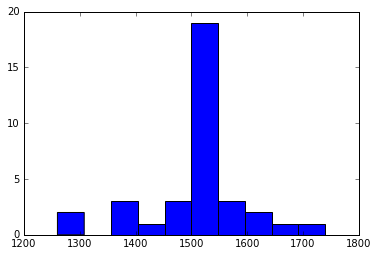

In [27]:
plt.hist(elo_df.elo)